In [7]:
from statsmodels.regression.rolling import RollingOLS
from joblib import Memory
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import plotly.graph_objects as go
from scipy.signal import argrelextrema
warnings.filterwarnings("ignore")

cachedir = "./yfinance_cache" 
memory = Memory(cachedir, verbose=0)


@memory.cache
def cached_yf_download(*args, **kwargs):
    return yf.download(*args, **kwargs)


@memory.cache
def cached_tickers(dt):
    sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
    sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-")
    symbols_list = sp500["Symbol"].unique().tolist()

    QQQ = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100#Components")[4]
    QQQ["Ticker"] = QQQ["Ticker"].str.replace(".", "-")
    nasdaq_symbols_list = QQQ["Ticker"].unique().tolist()

    symbols_list.extend(nasdaq_symbols_list)
    symbols_list.extend(["SPY","IVV","VOO","VTI","QQQ","VEA","IEFA","VTV","BND","VUG","AGG","IWF","IJR","IJH","IEMG","VWO","VIG","IWM","VXUS","VO","VGT","XLK","GLD","IWD","BNDX","XXXX","GBTC","SMH","IBIT","VGT","XLK","BITO"])
    symbols_list = list(set(symbols_list))

    return symbols_list


# end_date = '2023-11-21'
end_date = pd.Timestamp.now().floor("60T")
start_date = pd.to_datetime(end_date) - pd.DateOffset(1600)

symbols_list = cached_tickers("2023-12-12")

df = cached_yf_download(
    tickers=symbols_list, start=start_date, end=end_date, interval="1d", auto_adjust=True
).stack()

df.index.names = ["date", "ticker"]

df.columns = df.columns.str.lower()

df['dollar_volume'] = (df['close']*df['volume'])/1e6

all_tickers_df = df

all_tickers_df

[*********************100%%**********************]  550 of 550 completed


close        high         low        open  \
date       ticker                                                   
2019-09-10 A        72.449265   72.701197   71.015205   71.218686   
           AAL      28.919044   28.978630   28.015323   28.084841   
           AAPL     52.621040   52.640467   51.409326   51.931407   
           ABBV     55.679390   55.679390   53.613259   53.956252   
           ABT      77.101059   77.351241   75.071838   77.314176   
...                       ...         ...         ...         ...   
2024-01-26 ZBH     121.690002  123.110001  121.570000  122.839996   
           ZBRA    252.169998  258.420013  251.619995  256.980011   
           ZION     44.020000   44.860001   43.959999   44.500000   
           ZS      236.830002  239.839996  234.289993  236.880005   
           ZTS     191.520004  192.880005  188.970001  189.210007   

                        volume  dollar_volume  
date       ticker                              
2019-09-10 A         2838000.0     205.611013  
           AAL       6377300.0     184.425422  
           AAPL    127111600.0    6688.744632  
           ABBV     12155700.0     676.821960  
           ABT       5613100.0     432.775954  
...                        ...            ...  
2024-01-26 ZBH        982800.0     119.596934  
           ZBRA       268300.0      67.657211  
           ZION      1504900.0      66.245699  
           ZS        1204700.0     285.309103  
           ZTS       1840200.0     352.435112  

[599154 rows x 6 columns]

In [8]:
data = all_tickers_df

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(1*30, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

close        high         low        open      volume
date       ticker                                                            
2019-09-25 AAPL     53.672485   53.786615   52.727881   53.070271  87613600.0
           ABBV     58.872498   59.811650   58.815332   59.517654   5922700.0
           ABT      76.776764   76.952817   76.072558   76.350536   2795100.0
           ACN     178.776581  179.834989  176.753448  179.460339   2825100.0
           ADBE    277.429993  277.709991  267.730011  271.899994   3307300.0
...                       ...         ...         ...         ...         ...
2024-01-26 VZ       42.400002   42.490002   42.099998   42.290001  20364100.0
           WFC      50.320000   50.500000   49.770000   49.840000  19203100.0
           WMT     164.270004  164.380005  162.660004  163.050003   5248300.0
           XLK     201.750000  203.570007  201.289993  202.669998   5276500.0
           XOM     103.000000  103.080002  101.190002  101.970001  20809900.0

[162708 rows x 5 columns]

CMCSA is coming out of the squeeze. Advice: buy stock.


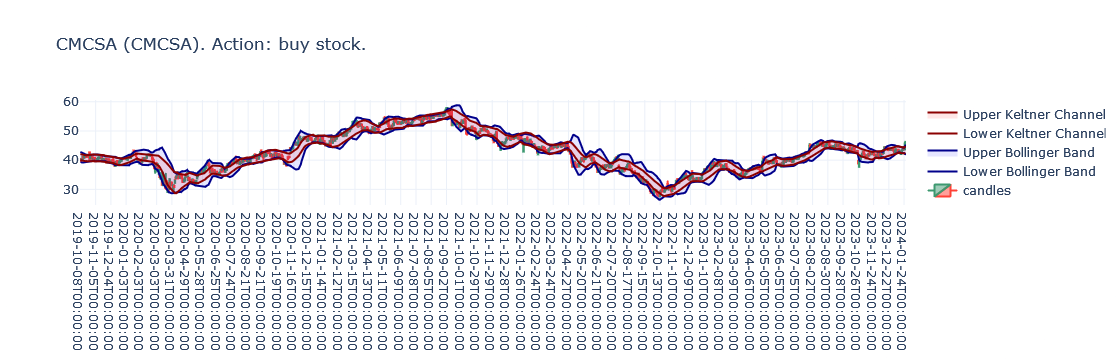

MPC is coming out of the squeeze. Advice: buy stock.


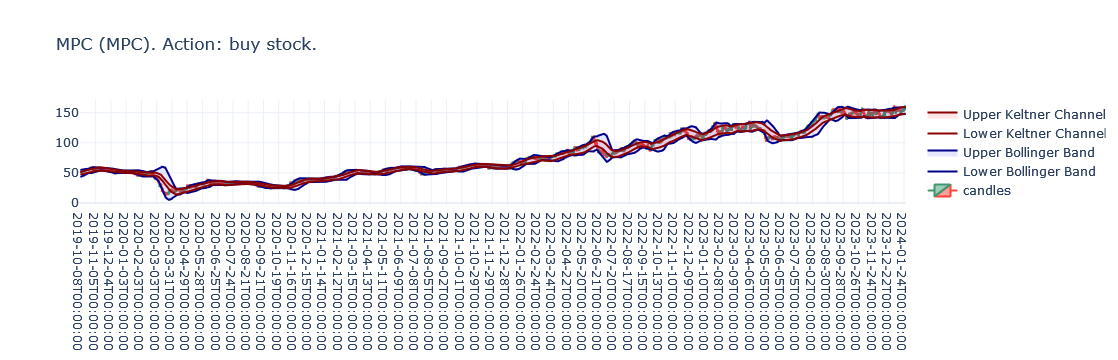

NOC is coming out of the squeeze. Advice: sell stock.


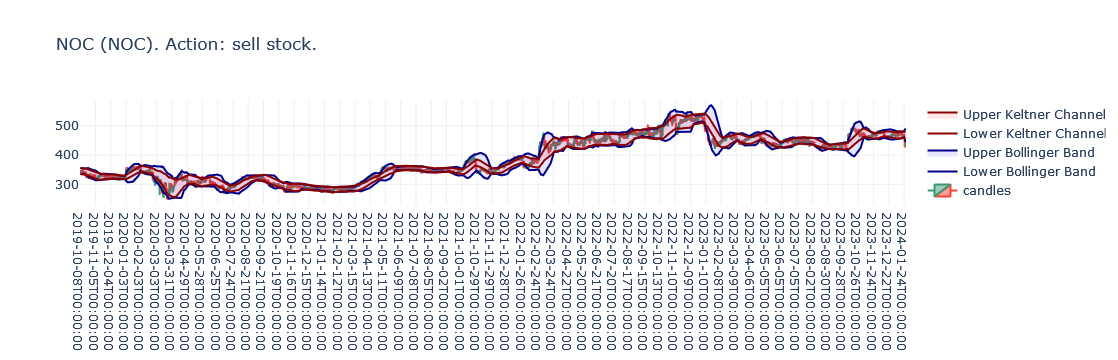

PDD is coming out of the squeeze. Advice: sell stock.


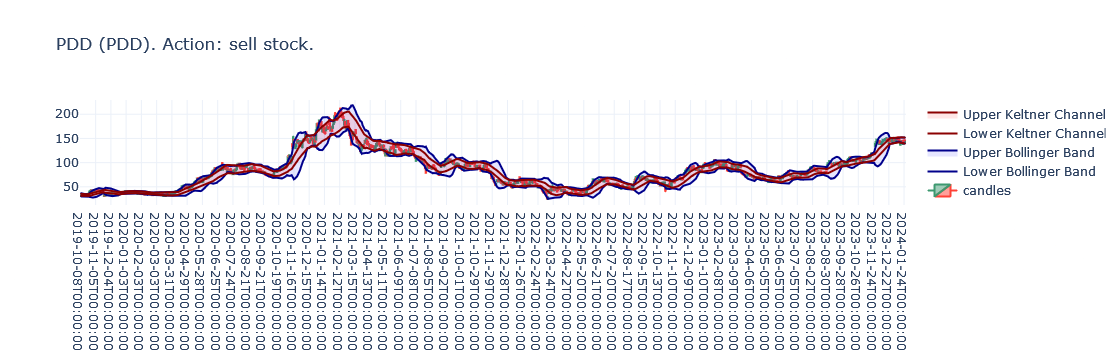

ULTA is coming out of the squeeze. Advice: buy stock.


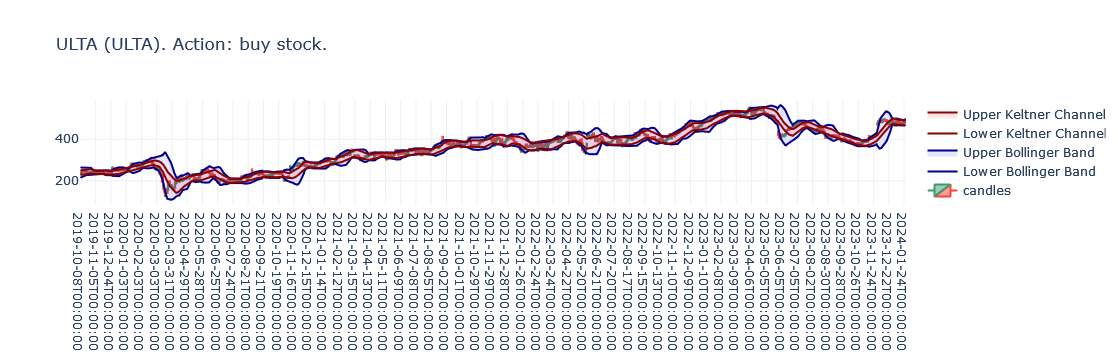

EA is coming out of the squeeze. Advice: buy stock.


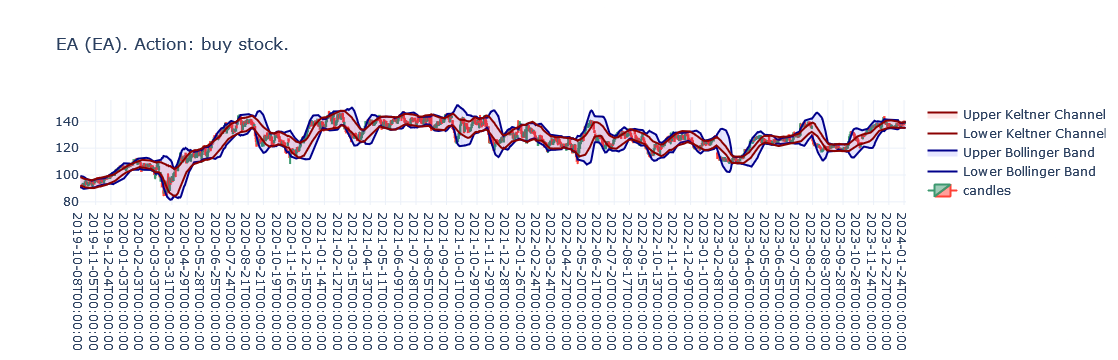

FLT is coming out of the squeeze. Advice: buy stock.


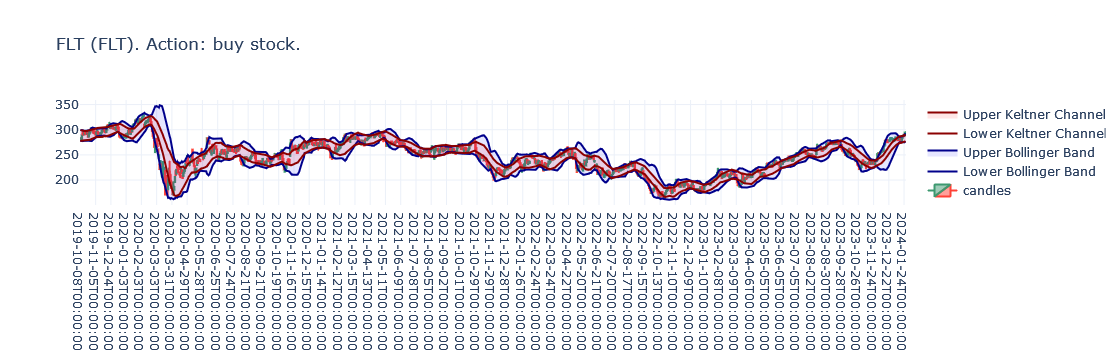

VTV is coming out of the squeeze. Advice: buy stock.


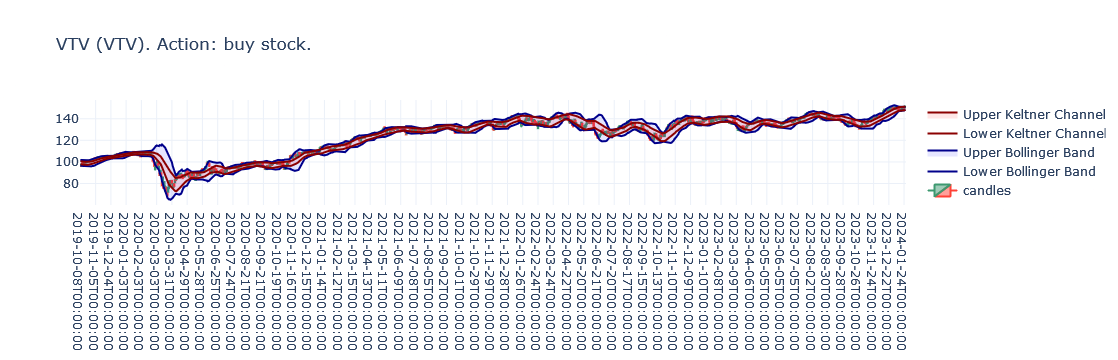

In [9]:
crosses = {}
squeeze = []
for symbol in data.index.unique(1):
    df = all_tickers_df.xs(symbol, level=1).drop_duplicates()
    
    df['20sma'] = df['close'].rolling(window=20).mean()
    df['50sma'] = df['close'].rolling(window=50).mean()
    df['200sma'] = df['close'].rolling(window=200).mean()
    df['Golden_Cross'] = (df['50sma'] > df['200sma']) & (df['50sma'].shift(1) <= df['200sma'].shift(1))
    df['Death_Cross'] = (df['50sma'] < df['200sma']) & (df['50sma'].shift(1) >= df['200sma'].shift(1))
    
    
    golden_signals = df[df['Death_Cross'] | df['Golden_Cross']]
    golden_signal = golden_signals.tail(1)
    if golden_signal is not None:
        distance_to_signal = pd.Timestamp.now() - golden_signal.index
        if distance_to_signal.days < 5:
            crosses[symbol] = golden_signal
    
    df['std'] = df['close'].rolling(window=20).std()
    
    df['low_bol'] = df['20sma'] - (2 * df['std'])
    df['upp_bol'] = df['20sma'] + (2 * df['std'])
    
    # compute Keltner's channel
    df['TR'] = df['high'] - df['low']
    df['ATR'] = df['TR'].rolling(window=20).mean()
    
    df['low_kel'] = df['20sma'] - df['ATR'] * 1.5
    df['upp_kel'] = df['20sma'] + df['ATR'] * 1.5
    
    # squeeze indicator
    def in_squeeze(df):
        return df['low_kel'] < df['low_bol'] < df['upp_bol'] < df['upp_kel']
    
    df['squeeze'] = df.apply(in_squeeze, axis=1)
    
    # stock is coming out of the squeeze
    if df.iloc[-3]['squeeze'] and not df.iloc[-1]['squeeze']:
        
        # decide which action to take by comparing distances                
        distance_to_upper = abs(df['upp_bol'].values[-1] - df['close'].values[-1])
        distance_to_lower = abs(df['low_bol'].values[-1] - df['close'].values[-1])
        
        if distance_to_upper < distance_to_lower:
            action = 'buy'
        else:
            action = 'sell'
        
        print(f'{symbol} is coming out of the squeeze. Advice: {action} stock.')
        squeeze.append({"symbol":symbol, "action":action})
        # initialize figure
        df = df.iloc[20:]
        
        candles = go.Candlestick(x=df.index, open=df['open'], high=df['high'],
                                 low=df['low'], close=df['close'], name='candles')
    
        upp_bol = go.Scatter(x=df.index, y=df['upp_bol'], name='Upper Bollinger Band', line={'color': 'darkblue'},
                             fill='tonexty', fillcolor='rgba(0,0,255,0.1)')
        low_bol = go.Scatter(x=df.index, y=df['low_bol'], name='Lower Bollinger Band', line={'color': 'darkblue'})
    
        upp_kel = go.Scatter(x=df.index, y=df['upp_kel'], name='Upper Keltner Channel', line={'color': 'darkred'},
                             fill='tonexty', fillcolor='rgba(255,0,0,0.1)')
        low_kel = go.Scatter(x=df.index, y=df['low_kel'], name='Lower Keltner Channel', line={'color': 'darkred'})

        
        # show figure
        fig = go.Figure(data=[candles, low_bol, upp_bol, low_kel, upp_kel])
        fig.layout.xaxis.type = 'category' # remove weekend days
        fig.layout.xaxis.rangeslider.visible = False
        fig.layout.xaxis.dtick = 20 # show x-axis ticker once a month
        
        company_name = symbol #Amsterdam_df[Amsterdam_df['Symbol'] == symbol]['Company Name'].values[0]
        fig.layout.title = f'{company_name} ({symbol}). Action: {action} stock.'
        fig.layout.template = 'plotly_white'
        fig.show()

In [10]:
all_crosses = []
for symbol, cross in crosses.items():
    cross['symbol'] = symbol
    cols = ['symbol'] + [col for col in cross.columns if col != 'symbol']
    cross = cross[cols]
    all_crosses.append(cross)
if len(all_crosses) > 0:
    crosses_df=pd.concat(all_crosses)
    crosses_df['signal'] = np.where(crosses_df['Golden_Cross']==True, 'buy', 'sell')
    crosses_df.drop(['high', 'low','open','volume','dollar_vol_rank','20sma','200sma','50sma','Golden_Cross','Death_Cross'], inplace=True, axis=1)
    print(crosses_df)
else:
    print('No golden crosses')
squeeze

           symbol       close  dollar_volume signal
date                                               
2024-01-26    DAL   39.630001     484.339102    buy
2024-01-23    EOG  110.370003     384.566277   sell
2024-01-24    HAL   36.830002     257.222182   sell
2024-01-25    MDT   85.790001     498.580996    buy
2024-01-23    MRK  119.839996     955.956878    buy
2024-01-23    MGM   43.049999     197.905587    buy
2024-01-24    BBY   73.330002     201.193763    buy
2024-01-26      O   54.970001     488.626167    buy


[{'symbol': 'CMCSA', 'action': 'buy'},
 {'symbol': 'MPC', 'action': 'buy'},
 {'symbol': 'NOC', 'action': 'sell'},
 {'symbol': 'PDD', 'action': 'sell'},
 {'symbol': 'ULTA', 'action': 'buy'},
 {'symbol': 'EA', 'action': 'buy'},
 {'symbol': 'FLT', 'action': 'buy'},
 {'symbol': 'VTV', 'action': 'buy'}]

In [11]:
df = all_tickers_df.xs("SPY", level=1).drop_duplicates()
df.dropna()
df['50sma'] = df['close'].rolling(window=50).mean()
df['200sma'] = df['close'].rolling(window=200).mean()
df['Golden_Cross'] = (df['50sma'] > df['200sma']) & (df['50sma'].shift(1) <= df['200sma'].shift(1))
df['Death_Cross'] = (df['50sma'] < df['200sma']) & (df['50sma'].shift(1) >= df['200sma'].shift(1))

golden_signals = df[df['Death_Cross'] | df['Golden_Cross']]
golden_signal = golden_signals.tail(1)
if golden_signal is not None:
    distance_to_signal = pd.Timestamp.now() - golden_signal.index
    if distance_to_signal.days < 5:
        print(golden_signal)




In [15]:
import math
import datetime
profits = None
buys = {}

for symbol in data.head(150).index.unique(1):
    rsi_buys=[]
    rsi_sells=[]
    
    df = all_tickers_df.xs(symbol, level=1).drop_duplicates()

    df['20sma'] = df['close'].rolling(window=20).mean()
    df['50sma'] = df['close'].rolling(window=50).mean()
    df['200sma'] = df['close'].rolling(window=200).mean()
    df['Golden_Cross'] = (df['50sma'] > df['200sma']) & (df['50sma'].shift(1) <= df['200sma'].shift(1))
    df['Death_Cross'] = (df['50sma'] < df['200sma']) & (df['50sma'].shift(1) >= df['200sma'].shift(1))
    
    df['price_change']=df['close'].pct_change()
    df['Upmove'] = df['price_change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['price_change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['avg_up'] = df['Upmove'].ewm(span=19).mean()
    df['avg_down'] = df['Downmove'].ewm(span=19).mean()
    df = df.dropna()
    df['RS'] = df['avg_up']/df['avg_down']
    df['RSI'] = df['RS'].apply(lambda x: 100-(100/(x+1)))
    
    def rsi_buy(df):
        return (df['close'] > df['200sma']) and df['RSI'] < 30
            
    
    df['RSI_Buy'] = df.apply(rsi_buy, axis=1)
    
    def rsi_sell(window):
        open_position = 0
        current_value = window.iloc[len(window)-1]
        blew_rsi = False
        
        for i in range(len(window)-1):
            old_value = window.iloc[len(window)-i-1]
            if old_value['RSI_Buy'] == False:
                continue
            open_position = i
            if current_value['RSI'] > 40:
                blew_rsi=True
    
        if open_position >= 10 or blew_rsi:
            return True
    
        return False
    
    results=[]
    for i in range(len(df)):
        window_df = df[max(i - 10+1,0):i+1]
        result = rsi_sell(window_df)
        results.append(result)
    
    df['RSI_Sell'] = results
    df['tx_price'] = df['open'].shift(-1)
    
    in_buy_phase = False
    
    def filter_signals(row):
        global in_buy_phase
        if row['RSI_Buy'] == True and not in_buy_phase:
            in_buy_phase = True
            return True
        if row['RSI_Sell'] == True and in_buy_phase:
            in_buy_phase = False
            return True
        return False
    
    df['keep'] = df.apply(filter_signals, axis=1)
    filtered_df = df[df['keep']].drop(columns='keep')
    
    filtered_df.drop(['high', 'low','price_change','volume','dollar_volume','avg_up','avg_down','Upmove','Downmove','dollar_vol_rank','20sma','200sma','50sma','Golden_Cross','Death_Cross','RS','RSI'], inplace=True, axis=1)
    
    filtered_df[filtered_df['RSI_Buy'] | filtered_df['RSI_Sell']]
    
    latest_buy = filtered_df[filtered_df['RSI_Buy']].tail(1)
    if (len(latest_buy) == 1):
        d = latest_buy.iloc[0].name.date()
        # print(f"{symbol}: {d}")
        now = datetime.datetime.now().date()
        isWithinDays = (now-d).days <= 10
        if (isWithinDays):
            print(f"{symbol}: {(d - now).days}: {d}")
            buys[symbol] = filtered_df
            
    if profits is None:
        profits = {}
    cash = 10000
    shares = None
    profits[symbol] = 0
    buy_price = None
    for index, row in filtered_df.iterrows():
        if row['RSI_Buy'] == True:
            buy_price = row['tx_price']
            if (cash > buy_price):
                shares = math.floor(cash/buy_price)
                cost = shares * buy_price
                cash -= cost
        elif row['RSI_Sell'] == True and shares is not None:
            cash +=  shares * row['tx_price']
            profits[symbol] = cash-10000
            shares = None
with pd.option_context('display.float_format', '{:0.2f}'.format):
    for buy in buys: 
        print(buy)
        print(buys[buy])


AMT: -3: 2024-01-24
MS: -10: 2024-01-17
SCHW: -9: 2024-01-18
AMT
            close   open  RSI_Buy  RSI_Sell  tx_price
date                                                 
2021-09-27 257.01 263.39     True     False    253.91
2021-10-14 251.17 248.90    False      True    252.97
2021-11-15 244.26 250.66     True     False    245.79
2021-11-24 248.93 246.49    False      True    249.96
2022-08-30 241.49 247.68     True     False    241.92
2022-09-07 247.30 242.94    False      True    247.45
2024-01-24 196.76 203.10     True     False    199.39
MS
            close  open  RSI_Buy  RSI_Sell  tx_price
date                                                
2020-09-22  42.94 43.49     True     False     43.15
2020-09-28  43.62 43.18    False      True     43.34
2021-06-18  77.10 79.21     True     False     77.54
2021-06-24  79.84 79.27    False      True     80.25
2021-09-21  90.79 91.83     True     False     91.83
2021-09-22  93.10 91.83    False      True     93.98
2023-03-09  89.48 92.5

In [16]:
if profits is not None:
    profits_df = pd.DataFrame.from_dict(profits, orient='index')
    profits_df.columns=['profit']
    profits_df
    print(profits_df['profit'].sum())

134630.7955042182
